In [1]:
import os
from pathlib import Path
import sys
import numpy as np
import scipy as sp
from typing import Tuple
from functools import partial
import matplotlib.pyplot as plt
sys.path.append(Path(os.getcwd()).parent)
import In_Chapter_Algos

## Problem 7

#### In order to make the neccesary modifications, note that we are originally solving the system $$Ax= b$$ conditioned on the first and last elements being 0. We can then ignore these components and only focus on the values of the interior points. For the general case, we can do exactly the same. The only change we make is that we enforce that they take specific non-zero values. This means that we need to subtract the components of these from $b$ as we do in the following code. 

In [2]:
def get_elt_arrays(h:float,p:np.array,
                   q:np.array,f:np.array,
                   ne:int)->Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """
    Takes in a set of p,q,f vectors represnenting difussion, advection
    and forcing terms respectively. Returns a tuple of tensors representing
    the difussion matrices, mass matrices, and forcing vectors associated to 
    each element. 

    Parameters:
    -----------
    h: float
        Length of the element in the natural units of the problem.
    p: np.array
        Array of diffussion coefficients for each element.
    q: np.array
        Array of advection coefficients for each element. 
    f: np.array
        Array of forcing terms for each element. 
    ne: int
        Number of elements. 

    Returns:
    --------
    Kks : np.ndarray
        Tensor where the first index determines the element, and the
        next two correspond to the difussion matrix associated with that 
        element. 
    Mks: np.ndarray
        Tensor where the first index determines the element, and the
        next two correspond to the difussion matrix associated with that 
        element. 
    bks: np.ndarray
        Tensor where the first index determines the element, and the
        next one corresponds to the contribution due to the left and 
        right terms respectively. 

    """
    #Initialize elements 
    Kks = np.zeros((ne,2,2))
    Mks =  np.zeros((ne,2,2))
    bks = np.zeros((ne,2))
    #Form Difussion matrices
    Kks[:,0,0] = p/h
    Kks[:,0,1] = -p/h
    Kks[:,1,0] = -p/h
    Kks[:,1,1] = p/h
    #Form mass matrices
    Mks[:,0,0] = q*h/3
    Mks[:,0,1] = q*h/6
    Mks[:,1,0] = q*h/6
    Mks[:,1,1] = q*h/3
    #Form bks
    bks[:,0] = f*h/2
    bks[:,1] = f*h/2
    return Kks, Mks, bks

def oned_linear_FEM_Dirichlet(ne:int,
                              p:np.array,
                              q:np.array,
                              f:np.array,
                              a:float=0,
                              b:float=1, 
                              left_val:float=0,
                              right_val:float=0
                              )->Tuple[np.array,np.array]:
    """
    A 1D finite element with tent functions
    method solver for general advection-difussion 
    equations with Dirichlet boundrary conditions
    in divergence form:

        -d/dx(p(x)du/dx)+q(x)u(x) = f(x) on x\in (a,b)
        u(a) = left_val
        u(b) = right_val

    Takes the number of elements you would wish to use
    and returns the points determined and the value of 
    the solution at those points. 

    Parameters:
    ----------
    ne: int
        Number of elements. 
    p: np.array
        Array of diffussion coefficients for each element.
    q: np.array
        Array of advection coefficients for each element. 
    f: np.array
        Array of forcing terms for each element. 
    a: float
        Left end point of the interval the function is to be 
        defined on.
    b: float 
        Right end point of the interval the function is to be 
        defined on.
    left_val: float
        Value the function must take on the left end point.
    right_val: float
        Value the function must take on the right end point. 

    Returns:
    --------
    xx: np.array
        Points in the interval the function was determined on
    u: np.array
        Values of the solution at the corresponding points. 
    
    """
    if b<=a:
        raise ValueError("b must be greater than a.")
    if not(p.ndim == 1 and q.ndim == 1 and f.ndim == 1):
        raise ValueError("p,q,h must all be vectors.")
    if not(len(p)==ne and len(q)==ne and len(f)==ne):
        raise ValueError("All arrays must be of length ne.")
    
    h = (b-a)/ne
    xx = np.arange(a,b+h,h)
    nvtx = len(xx)
    K = sp.sparse.lil_array((nvtx,nvtx))
    M = sp.sparse.lil_array((nvtx,nvtx))
    b = np.zeros(nvtx)
    Kks, Mks, bks = get_elt_arrays(h = h,
                                   p = p,
                                   q = q,
                                   f = f,
                                   ne = ne)

    for count in range(ne):
        K[count:count+2,count:count+2] += Kks[count,:,:]
        M[count:count+2,count:count+2] += Mks[count,:,:]
    b[:ne] = bks[:,0]
    b[-ne:] = bks[:,1]

    #Impose homogenous boundrary conditions
    A = K+M
    #This is the line we changed. It requires some special 
    modified_b = b-left_val*A.getcol(0).todense().flatten()-right_val*A.getcol(-1).todense().flatten()
    u_int = np.linalg.solve(A[1:-1,1:-1].todense(),modified_b[1:-1])
    u = np.zeros(nvtx)
    u[1:-1] = u_int
    u[0] = left_val
    u[-1] = right_val

    return xx, u

#### We can now use this to plot the function as desired. Due to the special form of p,q,f we can even compare it to the exact solution

(101,)


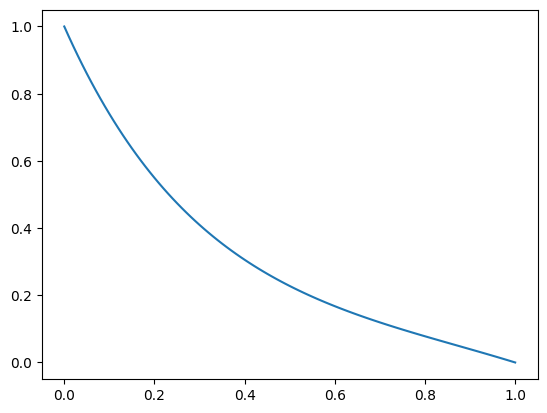

In [3]:
ne = 100
p = np.ones(ne)
q = np.ones(ne)*10
f = np.ones(ne)
xx,u = oned_linear_FEM_Dirichlet(ne = ne,
                                 p = p,
                                 q = q,
                                 f = f, 
                                 left_val = 1)

def true_solution(x:float,
                  p:float,
                  q:float,
                  f:float)->float:
    """
    True solution if p,q,f are constants
    on the domain [0,1]. 

    Parameters:
    ----------
    x: float
        Value to evaluate function at. 
        Must be between 0 and 1. 
    p: float
        Diffusion coefficient  
    q: float
        Advection coefficient
    f: float 
        Forcing coefficient

    Returns:
    -------
    val: float
    
    """
    if p<= 0 or q< 0: 
        raise ValueError("p must be postive, q must be non-negative. ")
    if x<0 or x>1:
        raise ValueError("x must be in the domain [0,1].")
    s = q/p 
    sqrt_s = np.sqrt(s)
    num = np.exp(sqrt_s*x)+np.exp(sqrt_s*(1-x))
    den = 1+ np.exp(sqrt_s)
    return f/q*(1-num/den)


plt.plot(xx,u)